In [1]:
import sys 

import numpy as np
import pandas as pd
import anndata
from copy import copy
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import scanpy as sc
from scipy.sparse import hstack

sys.path.extend(["../../..", "."])
from paths import DATA_DIR

### Util functions

In [2]:
def normalize_per_group(adata, obs_key):
    """
    Normalize adata within an adata category
    """
    adata_tmp = adata.copy()
    obs_cat = np.unique(adata_tmp.obs[obs_key])
    for obs in obs_cat:
        print(f"Normalize category: {obs}")
        X_norm = sc.pp.normalize_total(adata_tmp[adata_tmp.obs[obs_key]==obs, :], inplace=False)["X"] 
        adata_tmp[adata_tmp.obs[obs_key]==obs].X = X_norm                                                                                    
    return adata_tmp

### Preprocess

Read the data 

In [3]:
folder = DATA_DIR / "rawdata" / "unperturbed_time_course_processed"
adata_genesxcells = sc.read_mtx(folder / "matrix.mtx")

Transpose to have cell x genes

In [4]:
adata = anndata.AnnData(adata_genesxcells.X.T)
adata.X.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 1., 7.],
        [0., 0., 0., ..., 0., 0., 3.]], dtype=float32)

**Get the information on cells, barcodes and genes**

Read metadata associated to the AnnData 

In [5]:
barcode_path = folder / "barcodes.tsv"
cellidentity_path = folder / "cell_identities.csv"
genes_path = folder /"genes.tsv"

In [6]:
barcodes = pd.read_csv(barcode_path, sep="\t", header=None)
cellidentity = pd.read_csv(cellidentity_path)
genes = pd.read_csv(genes_path, sep="\t", header=None)

In [7]:
cellidentity

cell_barcode guide_identity  read_count  UMI_count   coverage  \
0      CGATTGACAGCGAACA-2  GFP_pBA571-59       29624        396  74.808081   
1      AAACGGGTCGTCACGG-2  GFP_pBA571-59       27369        368  74.372283   
2      GCGCAACCACATTCGA-2  GFP_pBA571-59       26865        342  78.552632   
3      GCTGCGAAGAGGTACC-2  GFP_pBA571-58       26823        423  63.411348   
4      TACTCATGTCAGAATA-2  GFP_pBA571-59       25175        349  72.134670   
...                   ...            ...         ...        ...        ...   
14502  GCCTCTAGTTCCCGAG-1              *           1          1   1.000000   
14503  GGAAAGCTCGTGGACC-2              *           1          1   1.000000   
14504  GGGACCTGTAGCTTGT-1              *           1          1   1.000000   
14505  GGTGTTAGTCTACCTC-1              *           1          1   1.000000   
14506  GTGAAGGTCACATGCA-2  GFP_pBA571-70           1          1   1.000000   

       gemgroup  good_coverage  number_of_cells  
0             2           True                1  
1             2           True                1  
2             2           True                1  
3             2           True                1  
4             2           True                1  
...         ...            ...              ...  
14502         1          False                0  
14503         2          False                0  
14504         1          False                0  
14505         1          False                0  
14506         2          False                0  

[14507 rows x 8 columns]

In [8]:
genes.columns = ["ENSMBL", "gene ID"]

**Read metadata**

In [9]:
metadata = pd.read_excel(folder / "unperturbed_time_course_processed.xlsx")

In [10]:
metadata

cell_barcode  gem_group  UMI_count  guide_UMI_count  \
0      AAACCTGAGCGTAGTG-1          1      13247               29   
1      AAACCTGAGGCTAGAC-1          1      14094               12   
2      AAACCTGCACGGTAGA-1          1      16487               73   
3      AAACCTGCAGGTCCAC-1          1      12119               61   
4      AAACCTGGTGGCCCTA-1          1      23214               56   
...                   ...        ...        ...              ...   
12914  TTTGTCATCATTGCGA-2          2      17438               34   
12915  TTTGTCATCCCAAGTA-2          2      20186               69   
12916  TTTGTCATCCCACTTG-2          2      30703               66   
12917  TTTGTCATCGTCACGG-2          2      58488               47   
12918  TTTGTCATCTGCAAGT-2          2      29633               40   

       guide_read_count  guide_coverage   MOI experimental_time  \
0                  1573           54.24   low              028h   
1                   487           40.58   low              096h   
2                  3266           44.74   low              028h   
3                  3859           63.26   low              048h   
4                  2714           48.46   low              072h   
...                 ...             ...   ...               ...   
12914              1848           54.35  high              072h   
12915              5235           75.87  high              048h   
12916              4618           69.97  high              048h   
12917              2754           58.60  high              048h   
12918              2278           56.95  high              048h   

      cell_cycle_phase  viral_load  interferon_score     cluster    UMAP_1  \
0                 M-G1    0.008908          1.815345   bystander -3.302532   
1                 G2-M    0.671137         -1.316287  infected_6 -1.101087   
2                    S    0.012373          1.377850   bystander -1.994823   
3                 G1-S    0.011965          0.612030   bystander -1.700732   
4                 G2-M    0.007625          0.733405   bystander -1.540104   
...                ...         ...               ...         ...       ...   
12914             M-G1    0.124326         -0.022159  infected_2  4.589217   
12915                S    0.035123         -1.130894  infected_2  6.416167   
12916             G1-S    0.036153         -0.488409  infected_2  6.270998   
12917                S    0.445698         -1.110313  infected_5  1.711608   
12918                S    0.422434         -1.064125  infected_5  2.245009   

          UMAP_2  
0      -0.172898  
1      11.574987  
2       0.308592  
3       1.202923  
4       1.291726  
...          ...  
12914  -0.501372  
12915  -3.043289  
12916  -3.114618  
12917  10.221025  
12918   9.726268  

[12919 rows x 14 columns]

Keep only cells that appear in the spreadsheet from the supplementary materials

In [11]:
cells_to_keep = barcodes.loc[barcodes.isin(np.array(metadata.cell_barcode))[0]]
# Get indexes
cells_to_keep_idx = np.array(cells_to_keep.index)

Keep only the cells that appear both in the metadata and cellidentity matrix

In [12]:
adata = adata[cells_to_keep_idx,:]

Transform time from string to float in metadata 

In [13]:
metadata.experimental_time = [float(time.split("h")[0]) for time in metadata.experimental_time]

Define the observation metadata

In [14]:
adata.obs = metadata

Define the gene metadata

In [15]:
adata.var = pd.DataFrame(genes)
adata.var.index = adata.var["gene ID"]
adata.var["mt"] = adata.var_names.str.startswith("MT-") 

Distinguish host and pathogen genes 

In [16]:
is_host = np.where(adata.var["ENSMBL"].str.startswith("ENSG"), True, False)
adata.var["is_host"]=is_host

**Pre-processing**

Highlight genes with more than 10000 transcripts (from the paper)

In [17]:
highly_expressed_genes = np.array((adata.X.todense().sum(0)>10000).astype(bool)).squeeze(0)
print(f"Number of genes with more than 10k counts: {np.sum(highly_expressed_genes)}")

Number of genes with more than 10k counts: 3588


In [18]:
adata.var["highly_variable"] = highly_expressed_genes

Subset the data to highly variable genes

In [19]:
adata = adata[:, adata.var["highly_variable"]]

Make variable names unique

In [20]:
adata.var_names_make_unique()

/nfs/homedirs/pala/miniconda3/envs/PerturbSeq_CMV/lib/python3.9/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


**Create high and low MOI subset**

In [21]:
adata_high = adata.copy()[adata.obs["MOI"]=="high", :]
adata_low = adata.copy()[adata.obs["MOI"]=="low", :]

adata_high.obs = adata_high.obs.reset_index()
adata_low.obs = adata_low.obs.reset_index()

Check how many clusters per timepoints in high and low MOI data 

In [22]:
pd.crosstab(adata_high.obs.cluster, adata_high.obs.experimental_time).sum(0)

experimental_time
0.0       446
6.0       837
20.0     1354
28.0     1672
48.0     1119
72.0      477
96.0      532
120.0     185
dtype: int64

In [23]:
pd.crosstab(adata_low.obs.cluster, adata_low.obs.experimental_time).sum(0)

experimental_time
0.0       451
6.0       606
20.0     1135
28.0     1494
48.0     1001
72.0      564
96.0      511
120.0     535
dtype: int64

**Separate the anndata for host and pathogen**

In [24]:
adata_host_high = adata_high[:, adata_high.var.is_host]
adata_viral_high = adata_high[:, ~adata_high.var.is_host]

adata_host_low = adata_low[:, adata_low.var.is_host]
adata_viral_low = adata_low[:, ~adata_low.var.is_host]

### Preprocess the host data 

In [25]:
sc.pp.normalize_total(adata_host_high)
sc.pp.log1p(adata_host_high)

sc.pp.normalize_total(adata_host_low)
sc.pp.log1p(adata_host_low)

/nfs/homedirs/pala/miniconda3/envs/PerturbSeq_CMV/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [26]:
sc.tl.pca(adata_host_high, svd_solver="arpack", use_highly_variable=True)
sc.tl.pca(adata_host_low, svd_solver="arpack", use_highly_variable=True)

In [27]:
sc.pp.neighbors(adata_host_high, n_pcs=30)
sc.pp.neighbors(adata_host_low, n_pcs=30)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [28]:
sc.tl.umap(adata_host_high)
sc.tl.umap(adata_host_low)

High MOI UMAP 

/nfs/homedirs/pala/miniconda3/envs/PerturbSeq_CMV/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


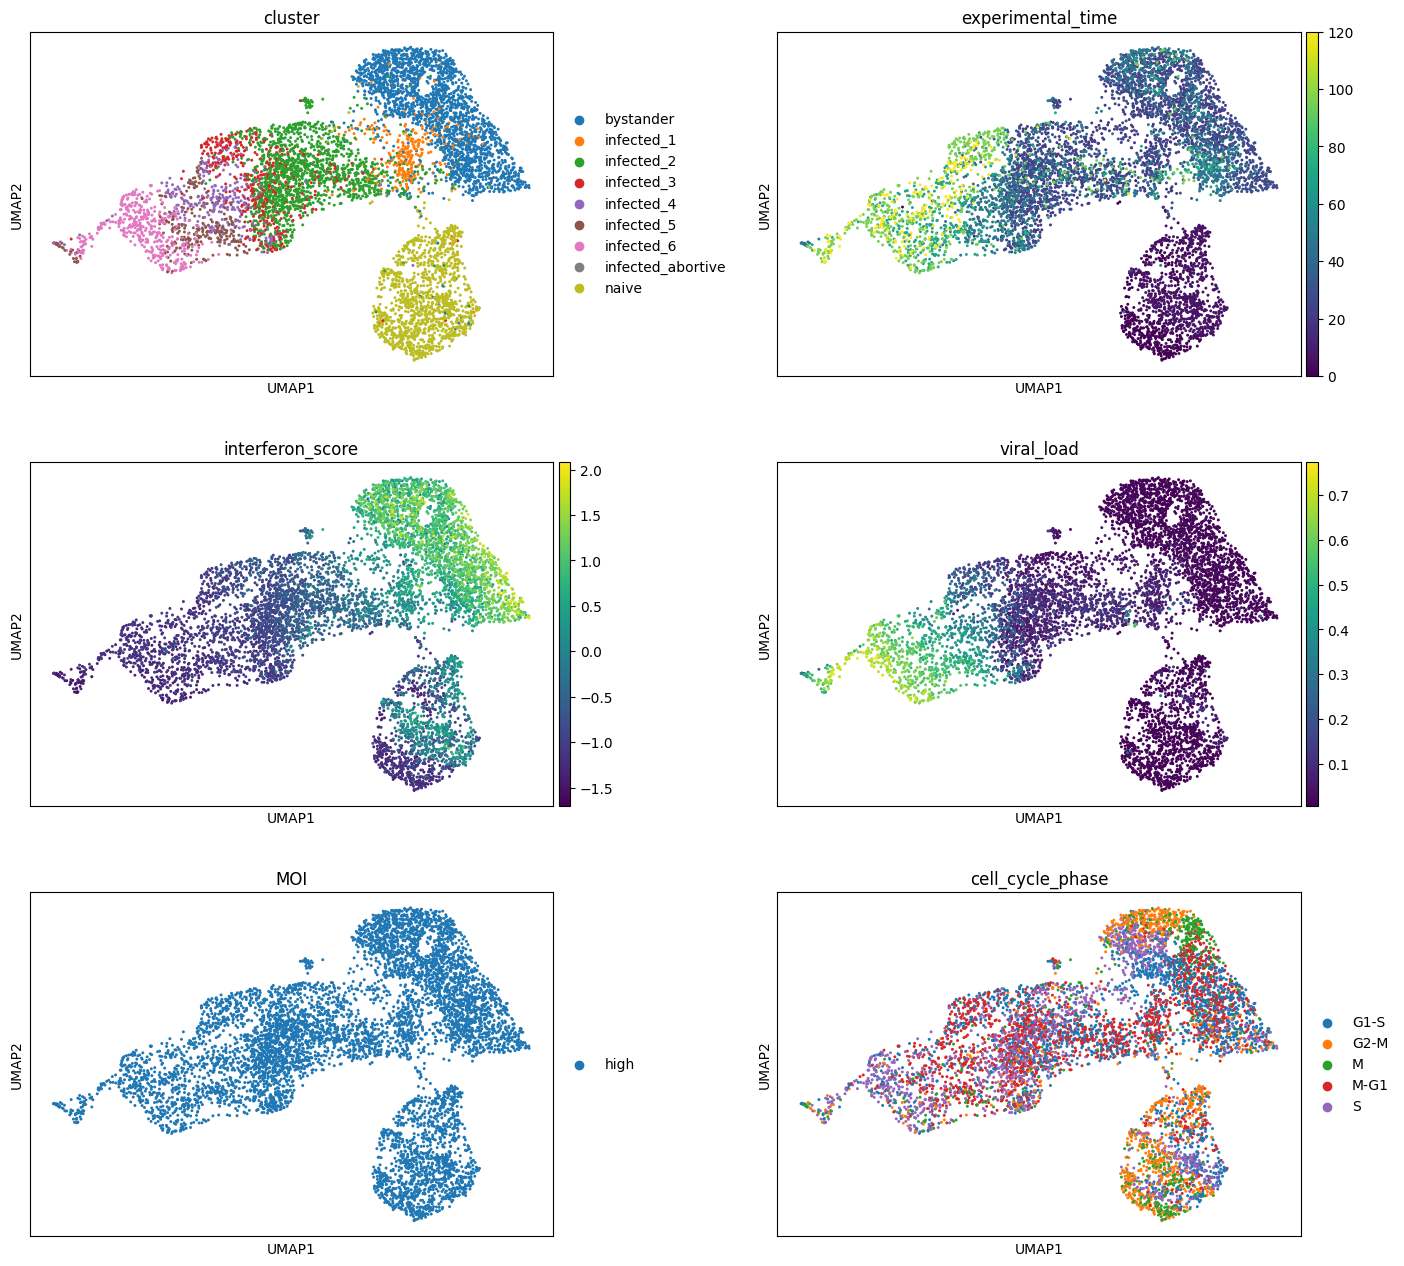

In [29]:
sc.pl.umap(adata_host_high, color=["cluster", "experimental_time", "interferon_score", "viral_load", "MOI", "cell_cycle_phase"], ncols=2, wspace=0.3)

Low MOI UMAP

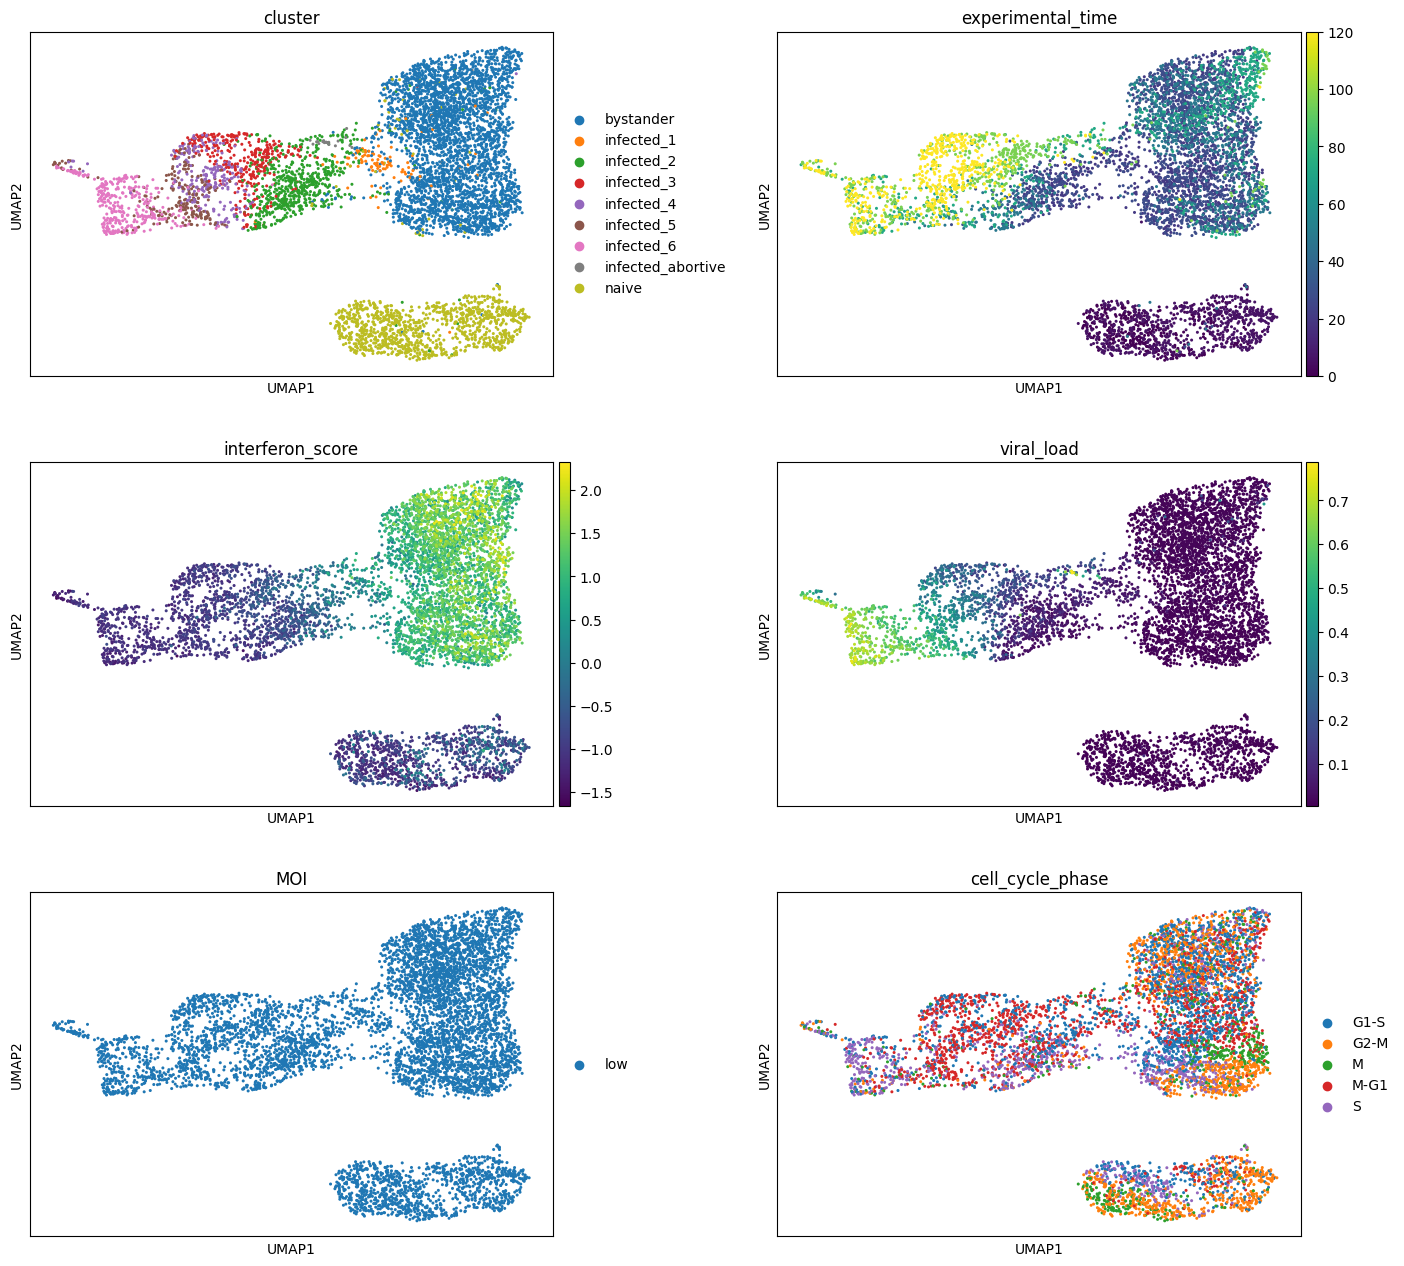

In [30]:
sc.pl.umap(adata_host_low, color=["cluster", "experimental_time", "interferon_score", "viral_load", "MOI", "cell_cycle_phase"], ncols=2, wspace=0.3)

In [31]:
adata_host_high.layers["X"] = adata_host_high.X
adata_host_low.layers["X"] = adata_host_low.X

### Preprocess the viral data 

In [32]:
sc.pp.log1p(adata_viral_high)
sc.pp.log1p(adata_viral_low)

/nfs/homedirs/pala/miniconda3/envs/PerturbSeq_CMV/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:373: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/nfs/homedirs/pala/miniconda3/envs/PerturbSeq_CMV/lib/python3.9/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [33]:
sc.tl.pca(adata_viral_high, svd_solver="arpack", use_highly_variable=True)
sc.tl.pca(adata_viral_low, svd_solver="arpack", use_highly_variable=True)

In [34]:
sc.pp.neighbors(adata_viral_high, n_pcs=30)
sc.pp.neighbors(adata_viral_low, n_pcs=30)

In [35]:
sc.tl.umap(adata_viral_high)
sc.tl.umap(adata_viral_low)

High MOI UMAP

/nfs/homedirs/pala/miniconda3/envs/PerturbSeq_CMV/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


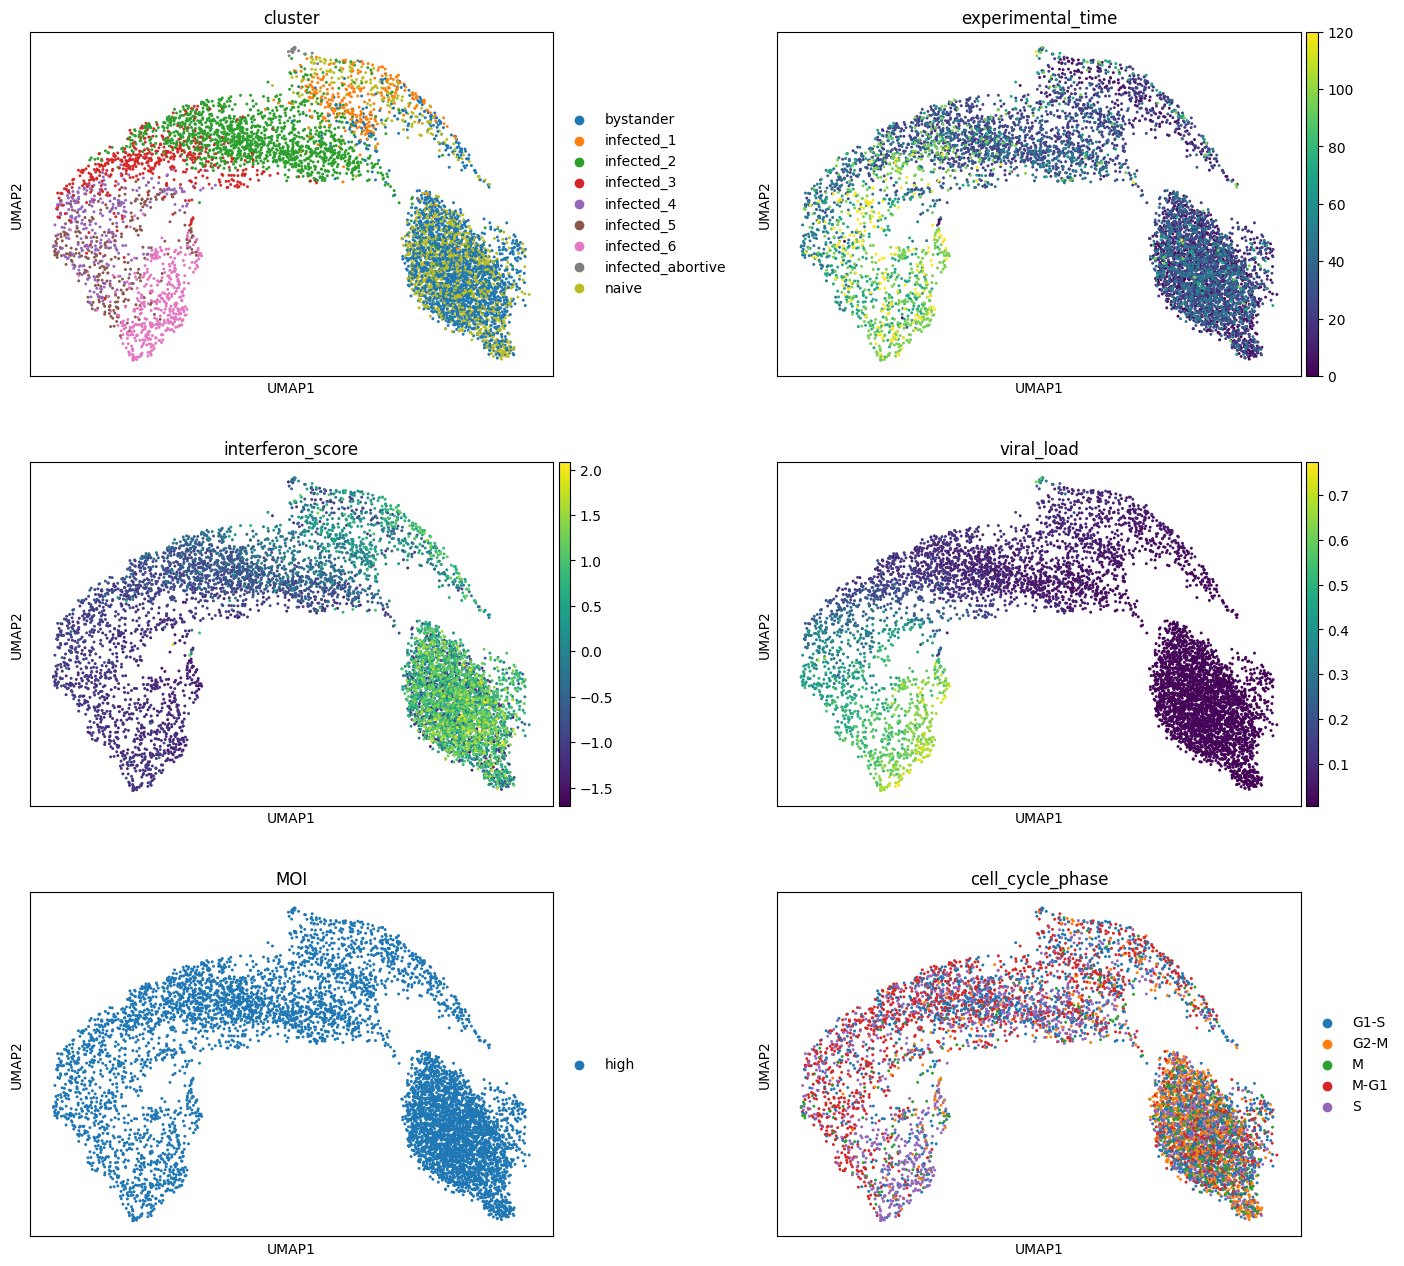

In [36]:
sc.pl.umap(adata_viral_high, color=["cluster", "experimental_time", "interferon_score", "viral_load", "MOI", "cell_cycle_phase"], ncols=2, wspace=0.3)

Low MOI UMAP

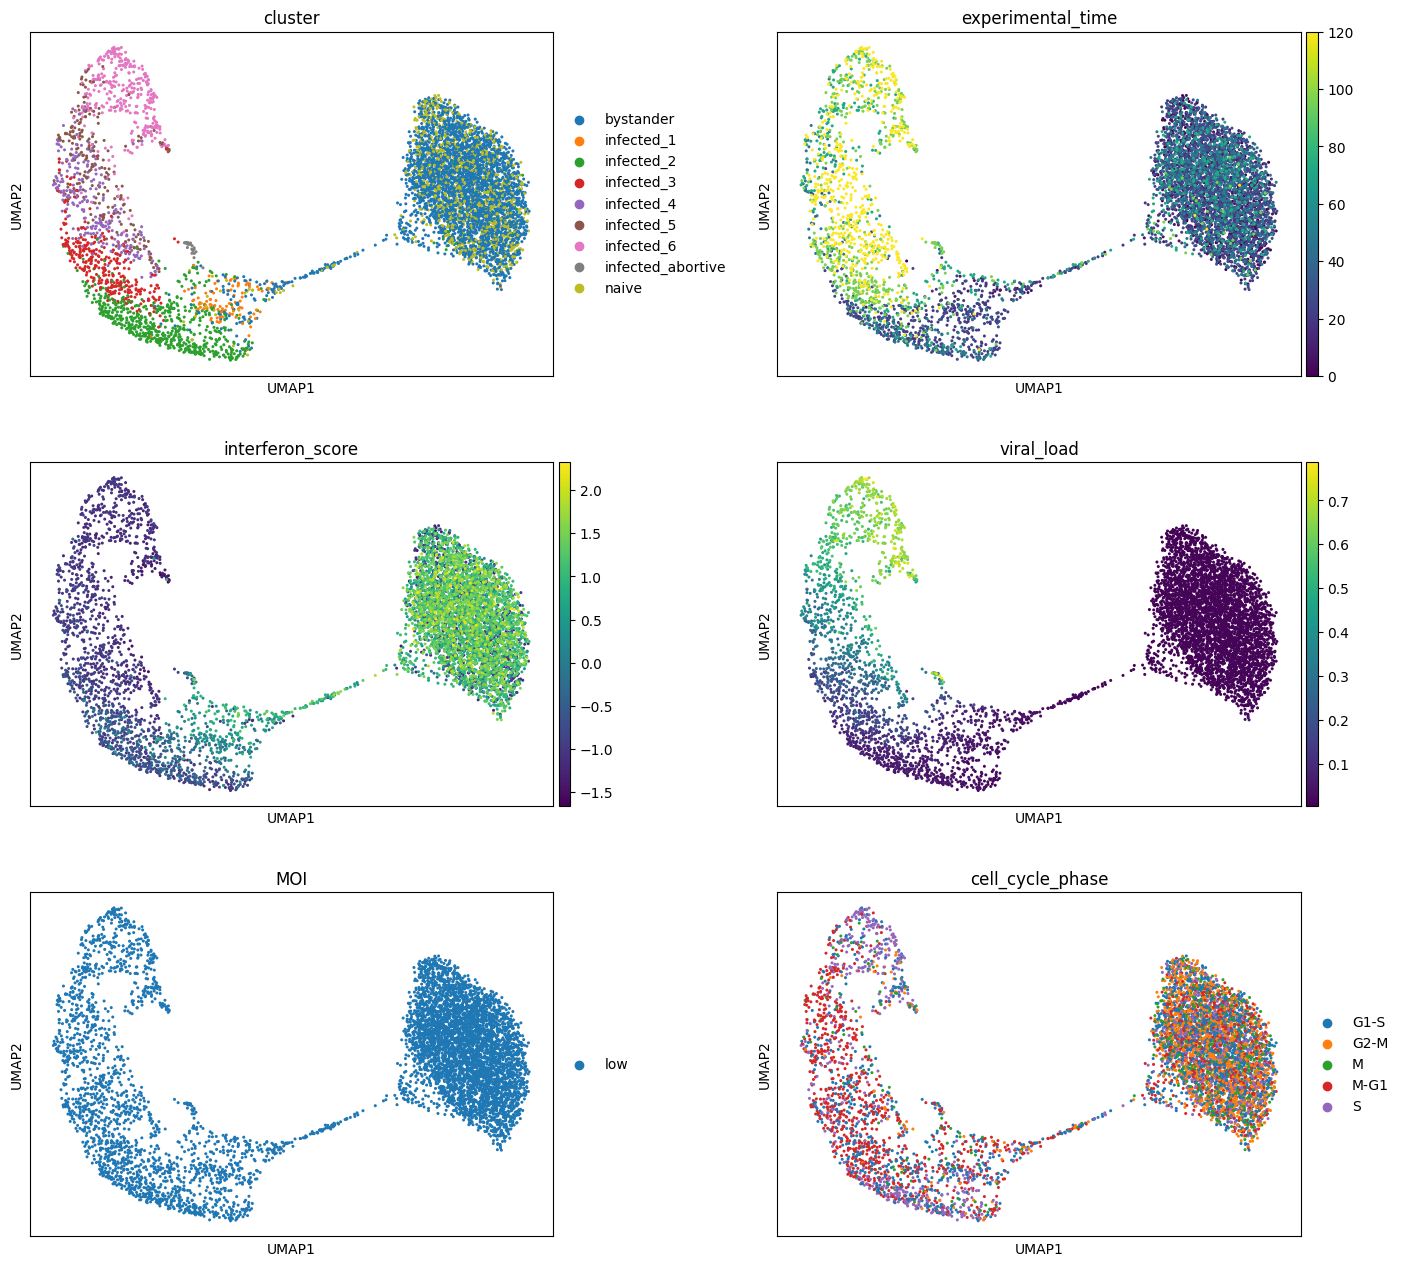

In [37]:
sc.pl.umap(adata_viral_low, color=["cluster", "experimental_time", "interferon_score", "viral_load", "MOI", "cell_cycle_phase"], ncols=2, wspace=0.3)

In [38]:
adata_viral_high.layers["X"] = adata_viral_high.X
adata_viral_low.layers["X"] = adata_viral_low.X

**Now consider the whole anndata**

In [39]:
adata_high.X = hstack((adata_host_high.X, adata_viral_high.X))
adata_low.X = hstack((adata_host_low.X, adata_viral_low.X))

Counts are already normalized in the processed datasets 

In [40]:
sc.tl.pca(adata_high, svd_solver="arpack", use_highly_variable=True)
sc.tl.pca(adata_low, svd_solver="arpack", use_highly_variable=True)

In [41]:
sc.pp.neighbors(adata_high, n_pcs=30)
sc.pp.neighbors(adata_low, n_pcs=30)

In [42]:
sc.tl.umap(adata_high)
sc.tl.umap(adata_low)

/nfs/homedirs/pala/miniconda3/envs/PerturbSeq_CMV/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


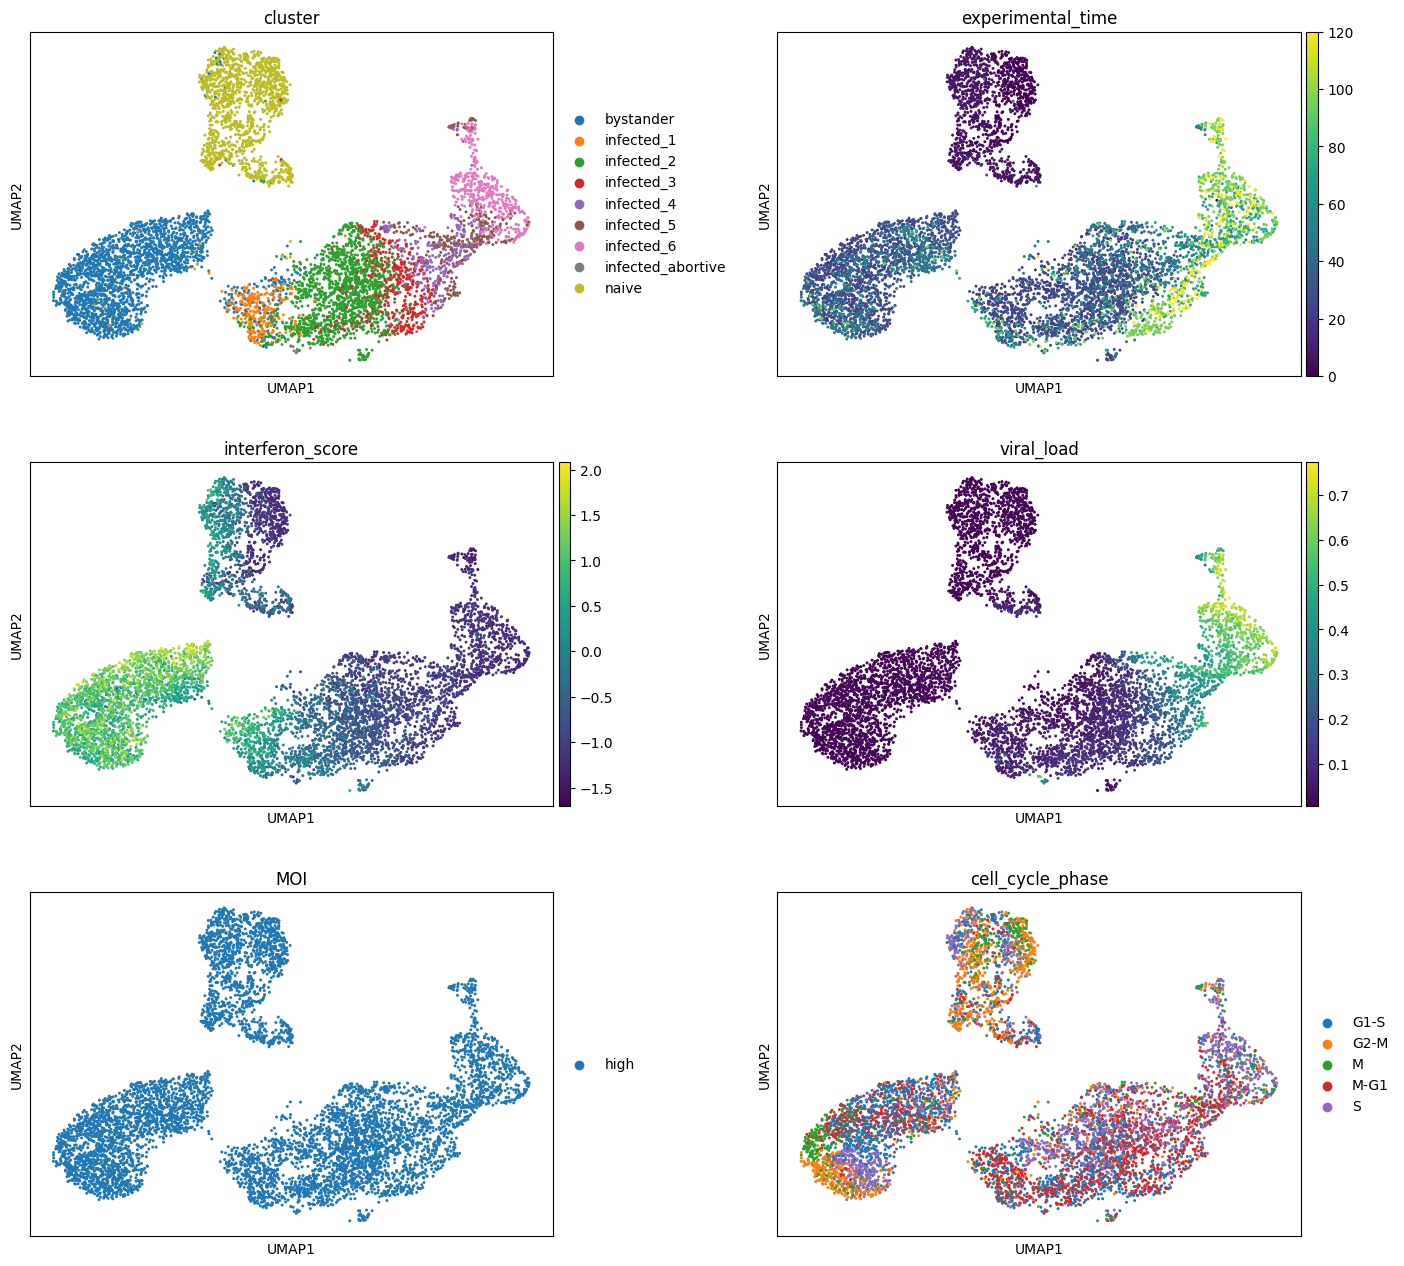

In [43]:
sc.pl.umap(adata_high, color=["cluster", "experimental_time", "interferon_score", "viral_load", "MOI", "cell_cycle_phase"], ncols=2, wspace=0.3)

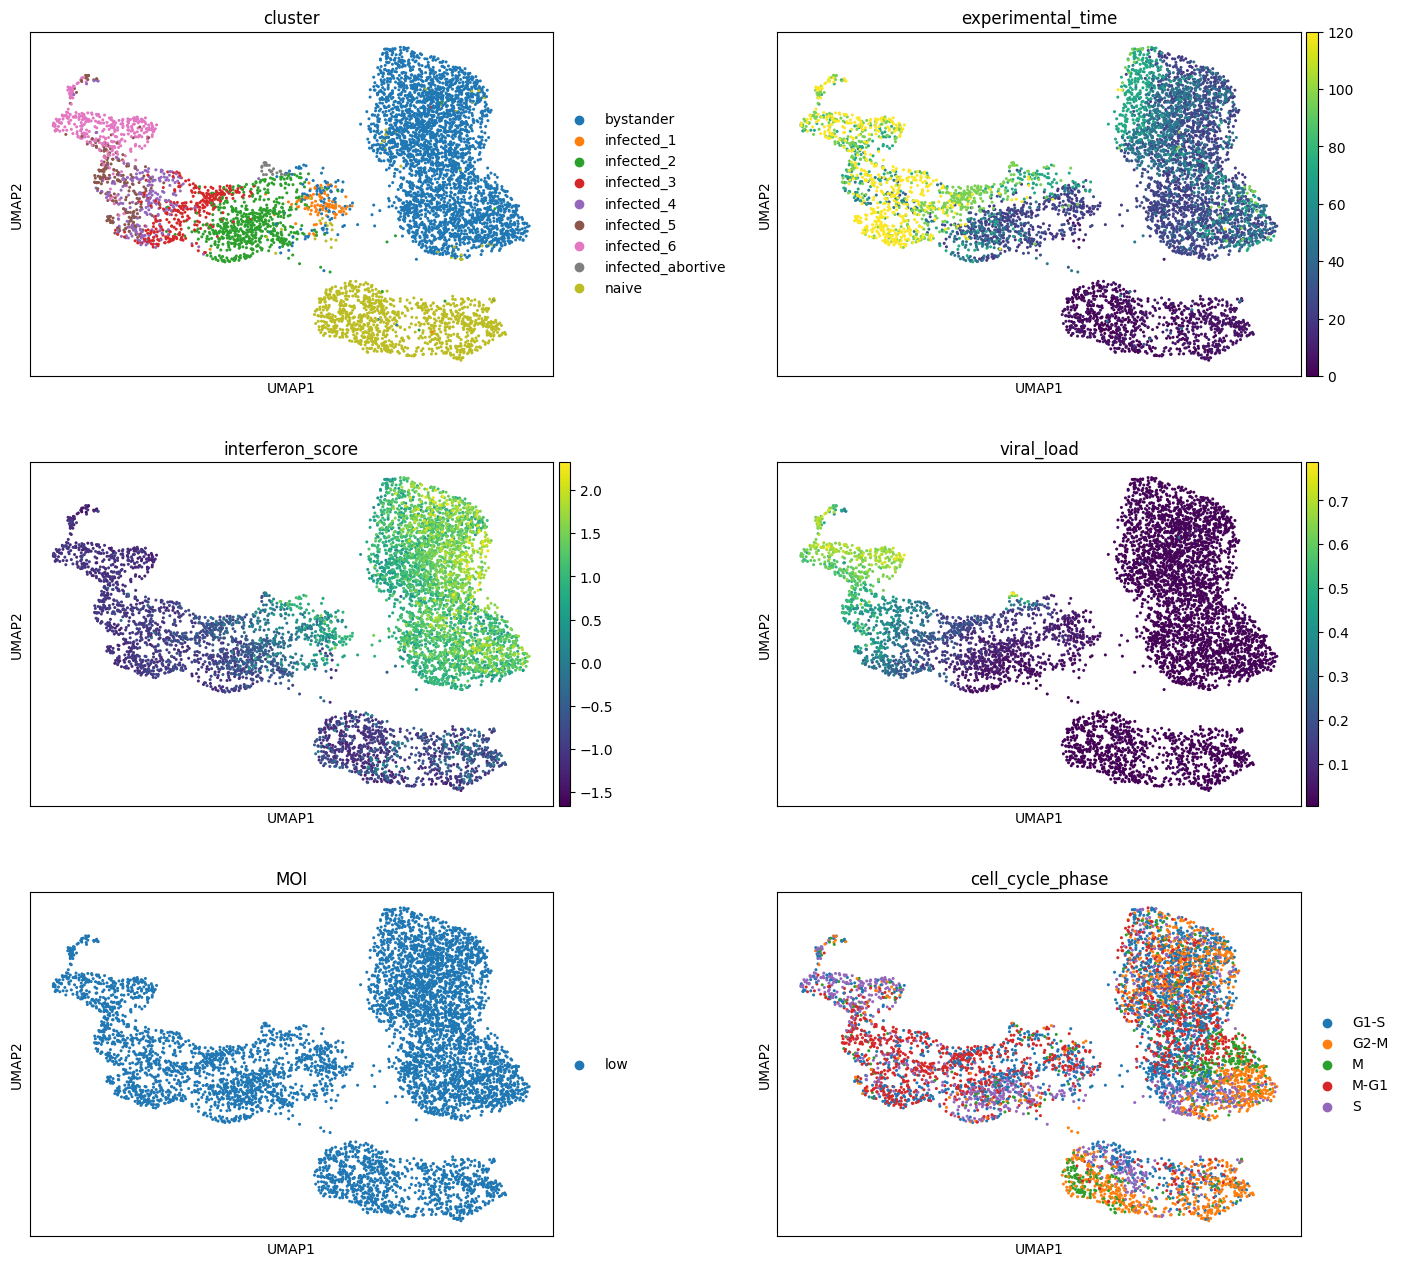

In [44]:
sc.pl.umap(adata_low, color=["cluster", "experimental_time", "interferon_score", "viral_load", "MOI", "cell_cycle_phase"], ncols=2, wspace=0.3)

In [45]:
adata_high.layers["X"] = adata_high.X
adata_low.layers["X"] = adata_low.X

**Save the anndata**

In [46]:
processed_data_dir = DATA_DIR / "processed"

In [47]:
adata_high.write(processed_data_dir / "unperturbed_time_course_high.h5ad")
adata_viral_high.write(processed_data_dir / "unperturbed_time_course_viral_high.h5ad")
adata_host_high.write(processed_data_dir / "unperturbed_time_course_host_high.h5ad")

adata_low.write(processed_data_dir / "unperturbed_time_course_low.h5ad")
adata_viral_low.write(processed_data_dir / "unperturbed_time_course_viral_low.h5ad")
adata_host_low.write(processed_data_dir / "unperturbed_time_course_host_low.h5ad")